In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Load the data into DataFrames
train_users = pd.read_csv('train_users_2.csv',na_values=['-unknown-'])
train_users['user_id'] = train_users['id']
train_users = train_users.drop(['id', 'date_first_booking'], axis = 1)

test_users = pd.read_csv('test_users.csv', na_values=['-unknown-'])
test_users['user_id'] = test_users['id']
test_users = test_users.drop(['id', 'date_first_booking'], axis = 1)


print("number of users", train_users.shape[0], "user in the testset", 
      test_users.shape[0])
print("In total", train_users.shape[0] + test_users.shape[0], "users.")

('number of users', 213451, 'user in the testset', 62096)
('In total', 275547, 'users.')


# Merge train and test users

In [39]:

users = pd.concat((train_users, test_users), axis=0, ignore_index=True)
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
age                        158681 non-null float64
country_destination        213451 non-null object
date_account_created       275547 non-null object
first_affiliate_tracked    269462 non-null object
first_browser              231153 non-null object
first_device_type          275547 non-null object
gender                     146067 non-null object
language                   275546 non-null object
signup_app                 275547 non-null object
signup_flow                275547 non-null int64
signup_method              275547 non-null object
timestamp_first_active     275547 non-null int64
user_id                    275547 non-null object
dtypes: float64(1), int64(2), object(12)
memory usage: 31.5+ MB


# CLeaning data :

fixing up format/filling in missing values/correcting erroneous values/standardizing categorical values

In [40]:
#fixing format date
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'].fillna(users.timestamp_first_active, inplace=True)

In [41]:
users = users.set_index('user_id', drop = True)
targets = users['country_destination']
data = users.drop('country_destination', axis = 1)

# Filling missing values

In [42]:
#spot mssing values
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')


age                        42.412365
first_affiliate_tracked     2.208335
first_browser              16.111226
gender                     46.990169
language                    0.000363
dtype: float64

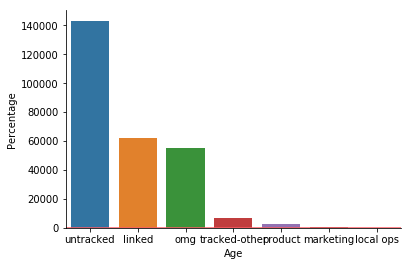

In [43]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()
plt.show()

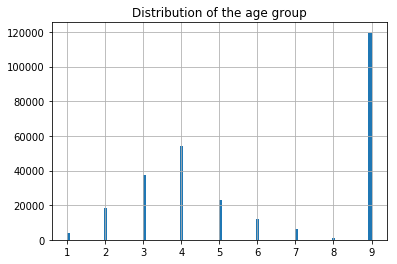

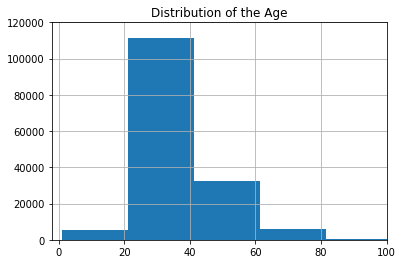

In [44]:
bins = [-1, 20, 25, 30, 40, 50, 60, 75, 100]
users['age_group'] = np.digitize(users['age'], bins, right=True)

users.age_group.hist(bins=100)
plt.title('Distribution of the age group')

plt.show()

users['age'].hist(bins=100)
plt.axis([-2,100,0,120000])
plt.title('Distribution of the Age')
plt.show()


In [45]:
#fill the value with nan for age and correct erroneous values
users['age'] = users['age'].apply(lambda x: 2015-x if (x >1905,x <2002) else x)

users['age'] = users['age'].apply(lambda x: np.nan if x < 14 else x)
users['age'] = users['age'].apply(lambda x: np.nan if x >=2002 else x)


#recognize NaN value
users['age'].fillna(-1, inplace=True)
df = users["age"]
df.isnull().sum()

0

In [46]:
#first_affiliate_tracked

sns.countplot(x="first_affiliate_tracked", data=users, order=list(users.first_affiliate_tracked.value_counts().keys()))
plt.xlabel('first_affiliate_tracked')
plt.ylabel('Percentage')
sns.despine()
# Fill first_affiliate_tracked column
users.first_affiliate_tracked.fillna('untracked', inplace = True)


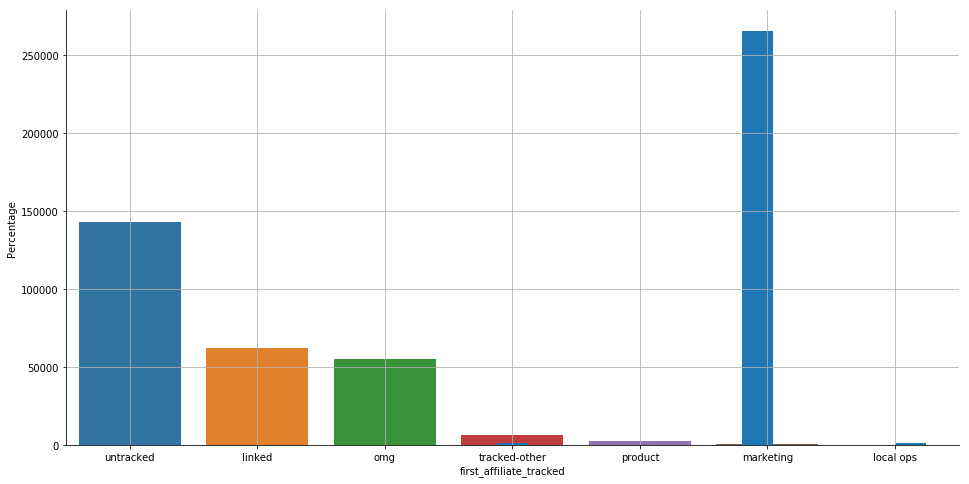

In [47]:
users.language.hist(figsize = (16,8), bins = 100 )
plt.show()
# replacing the missing value in language by english 
users.language.fillna(value = 'en', inplace = True)

In [48]:
users['train'] = targets.notnull()*1
col_obj = data.columns[data.dtypes == 'object']

In [49]:
for col in col_obj:
    data = pd.get_dummies(data, columns=[col], prefix = col + '_')

In [ ]:
def transform_cyclical_data(x):
    day = x.day
    month = x.month
    hour = x.time().hour*60+x.time().minute
    hour_sin = np.sin(hour*2*np.pi/(24*60))
    hour_cos = np.cos(hour*2*np.pi/(24*60))
    month_cos = np.cos(month*2*np.pi/12)
    month_sin = np.sin(month*2*np.pi/12)
    week_day = x.weekday()
    week_day_cos = np.cos(week_day*2*np.pi/7)
    week_day_sin = np.sin(week_day*2*np.pi/7)
    return [day, month_cos, month_sin, hour_cos, hour_sin, week_day_cos, week_day_sin]

In [50]:
data.to_csv('data_cleaned/full_cleaned_users_data.csv', index = True)
targets.to_csv('data_cleaned/targets.csv', index = True)